# HW08

## Exercises to practice pandas, data analysis, regression and classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LFWUtils
from data_utils import LinearRegression, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [4]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [5]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

age 17 58 29.74535714285714
gender 0.0 1.0 0.6726785714285715
height 56 94 68.24732142857142
weight 0 321 174.55839285714285
span 1323 2121 1763.703392857143
stature 1409 1993 1714.265357142857
ear.breadth 25 46 35.128928571428574
ear.length 46 81 62.637142857142855
ear.protrusion 13 34 22.266785714285714
foot.breadth 77 126 98.85089285714285
foot.length 198 323 262.9919642857143
hand.breadth 67 105 84.93696428571428
hand.length 145 239 189.26017857142858
hand.palm 88 140 113.91964285714286
head.height 206 295 249.17089285714286
head.circumference 502 635 570.0628571428572


,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
age,1.000179,0.062201,0.029467,0.217017,0.064304,0.037972,0.187740,0.292098,-0.009254,0.064993,0.048699,0.133830,0.104642,0.120726,0.038637,0.014044
gender,0.062201,1.000179,0.656634,0.562369,0.648306,0.663334,0.410499,0.463540,0.413054,0.641221,0.669078,0.746050,0.495310,0.508053,0.559495,0.339537
height,0.029467,0.656634,1.000179,0.659590,0.869103,0.959988,0.355310,0.421910,0.283853,0.662081,0.820186,0.712196,0.736264,0.695159,0.554231,0.439234
weight,0.217017,0.562369,0.659590,1.000179,0.662828,0.682587,0.361981,0.487481,0.242281,0.708759,0.688228,0.710663,0.599894,0.591608,0.521809,0.540160
span,0.064304,0.648306,0.869103,0.662828,1.000179,0.899400,0.348283,0.401564,0.268229,0.681016,0.862806,0.731574,0.844382,0.796280,0.536677,0.476903
stature,0.037972,0.663334,0.959988,0.682587,0.899400,1.000179,0.365847,0.438604,0.289324,0.677517,0.844233,0.727613,0.761877,0.720473,0.577022,0.462999
ear.breadth,0.187740,0.410499,0.355310,0.361981,0.348283,0.365847,1.000179,0.454968,0.240675,0.367536,0.385165,0.415684,0.341742,0.293001,0.277395,0.221058
ear.length,0.292098,0.463540,0.421910,0.487481,0.401564,0.438604,0.454968,1.000179,0.382646,0.436241,0.419030,0.465829,0.335176,0.341726,0.384718,0.283878
ear.protrusion,-0.009254,0.413054,0.283853,0.242281,0.268229,0.289324,0.240675,0.382646,1.000179,0.294336,0.279865,0.316847,0.194417,0.204587,0.273468,0.124790
foot.breadth,0.064993,0.641221,0.662081,0.708759,0.681016,0.677517,0.367536,0.436241,0.294336,1.000179,0.759427,0.789143,0.661091,0.639648,0.547463,0.492590


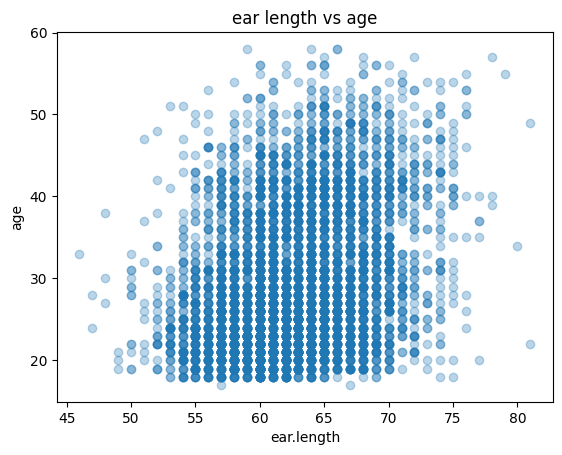

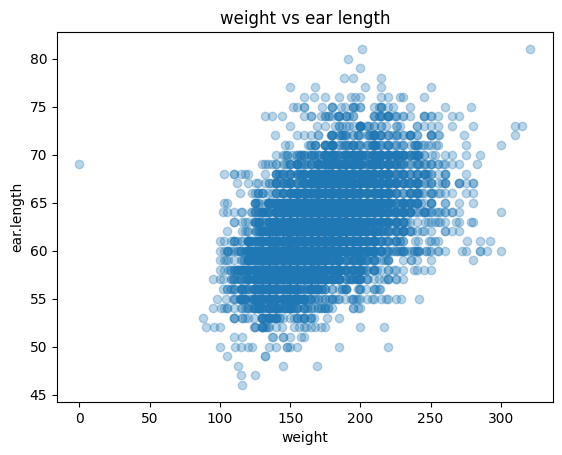

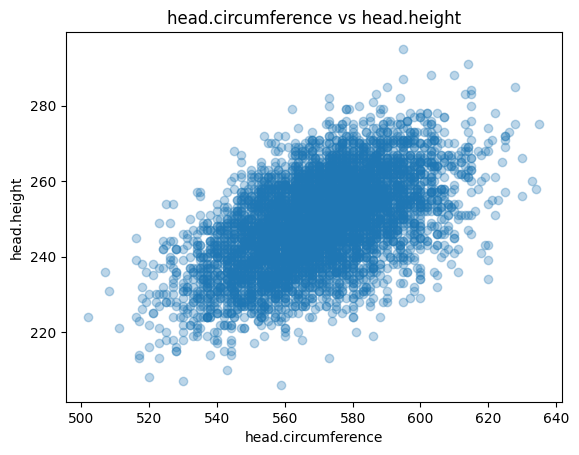

In [6]:
# Work on Data Exploration here

### Encode non-numerical features
gender = ['F', 'M']

ansur_encoder = OrdinalEncoder(categories=[gender])

ccc_vals = ansur_encoder.fit_transform(ansur_df[["gender"]].values)
ansur_df[["gender"]] = ccc_vals
## 1. Print min, max, avg
for x in ansur_df:
    print(x,min(ansur_df[x]),max(ansur_df[x]),ansur_df[x].mean())
### Normalize all data
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df)
## 2. Print Covariances
display(ansur_scaled.cov())
## 3. Plot features most correlated to age, ear length and head circumference
# age and ear length
plt.plot(ansur_df["ear.length"], ansur_df["age"],marker='o', linestyle='', alpha=0.3)
plt.title("ear length vs age")
plt.xlabel("ear.length")
plt.ylabel("age")
plt.show()
# ear length and weight
plt.plot(ansur_df["weight"], ansur_df["ear.length"],marker='o', linestyle='', alpha=0.3)
plt.title("weight vs ear length")
plt.xlabel("weight")
plt.ylabel("ear.length")
plt.show()
# head circumferance and head height
plt.plot(ansur_df["head.circumference"], ansur_df["head.height"],marker='o', linestyle='', alpha=0.3)
plt.title("head.circumference vs head.height")
plt.xlabel("head.circumference")
plt.ylabel("head.height")
plt.show()


### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:blue;">The feature most correlated to ear length is not the same one that ear length is related to. I think head height and head circumfernace seem the post related based on the graphs, and logically that makes sense, and I think its weird that weight and ear length have such a strong correlation.</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

In [7]:
# Work on Regression Model here

## Separate outcome variable and input features
head_circ = ansur_scaled["head.circumference"]
features = ansur_scaled.drop(columns=["head.circumference"])
## Create a regression model
head_circ_model = LinearRegression()
## Measure error on training data
head_circ_model.fit(features, head_circ)

predicted_scaled = head_circ_model.predict(features)
## Plot predictions and interpret results
predicted = ansur_scaler.inverse_transform(predicted_scaled)

## 7. Measure error
regression_error(ansur_df["head.circumference"], predicted["head.circumference"])

np.float64(13.910571985204234)

In [8]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

########## NOTE I HAD TO EDIT THIS TO MAKE IT RUN NOT SURE WHY IT WASNT WORKING BEFORE
ansur_test_encoded_df = ansur_test_df.copy()
ansur__test_encoder = OrdinalEncoder(categories=[gender])
g_vals = ansur__test_encoder.fit_transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

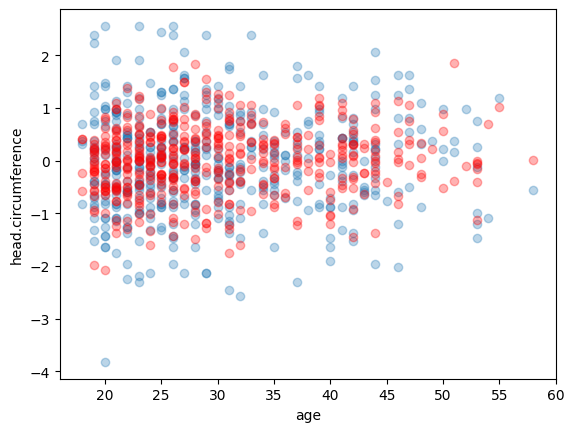

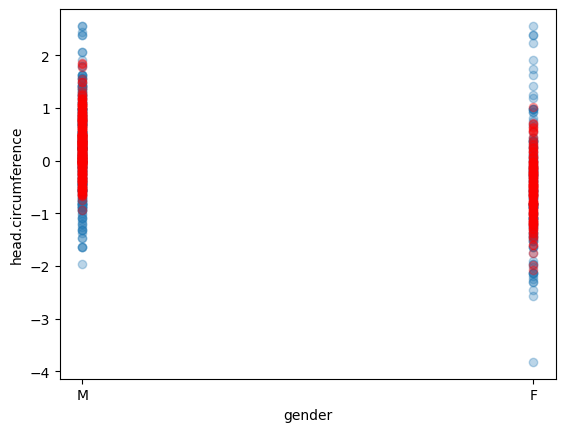

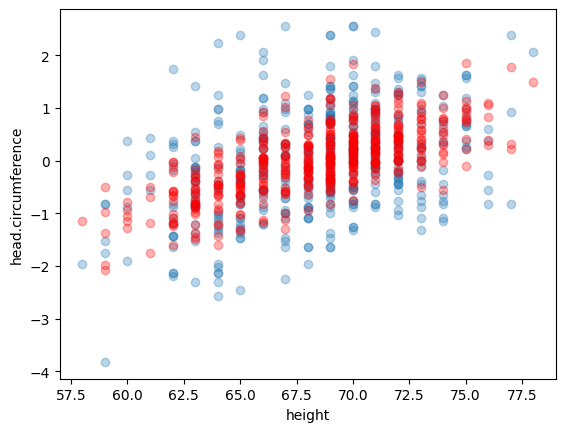

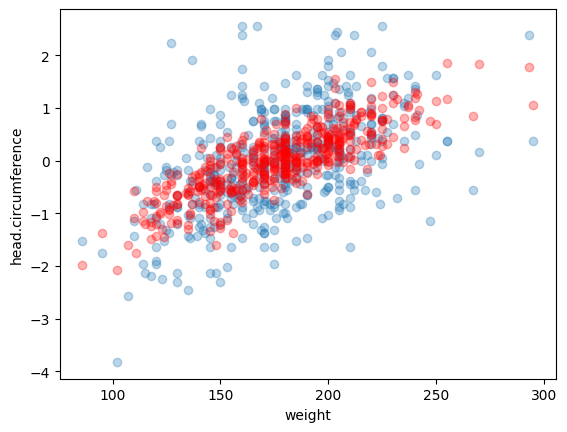

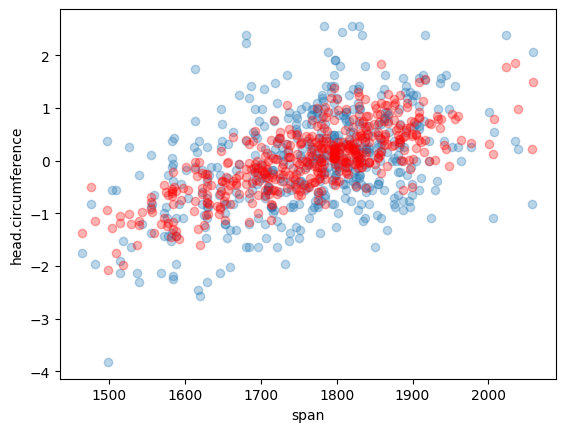

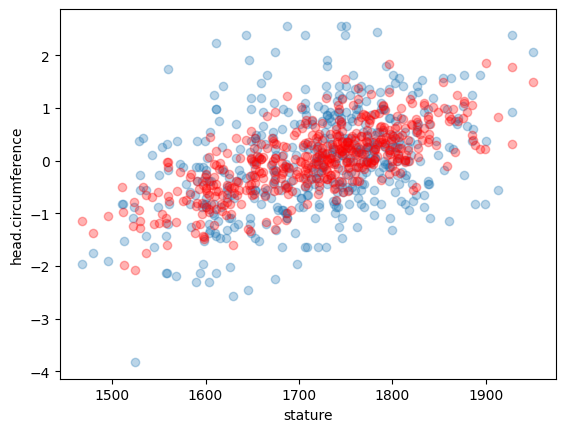

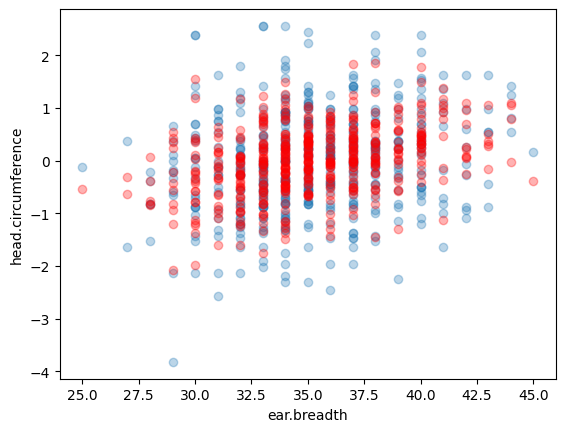

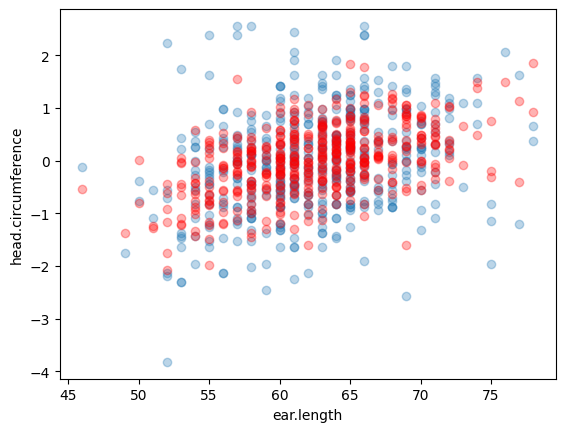

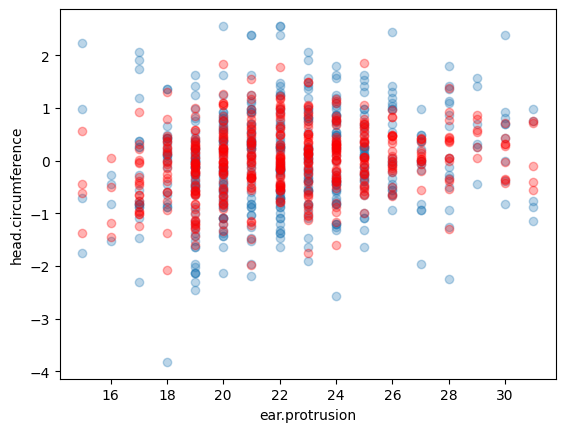

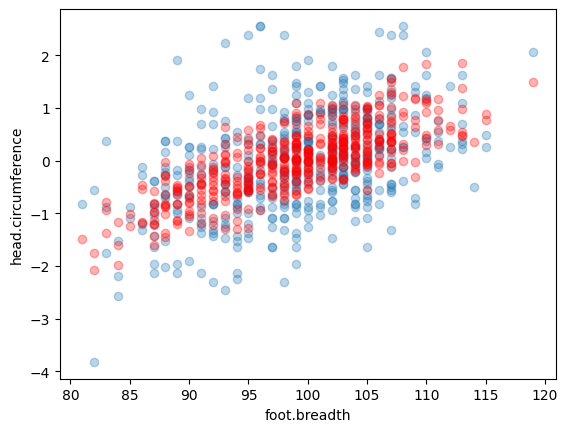

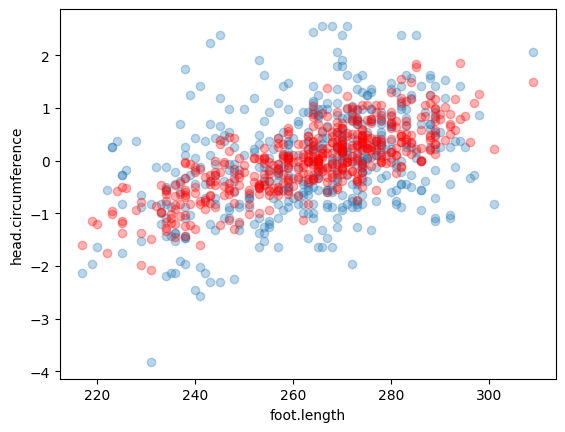

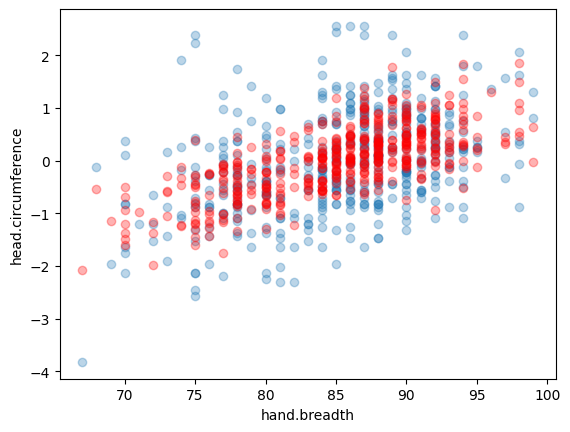

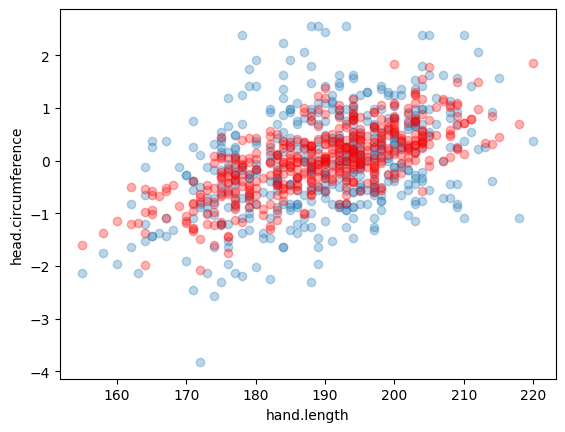

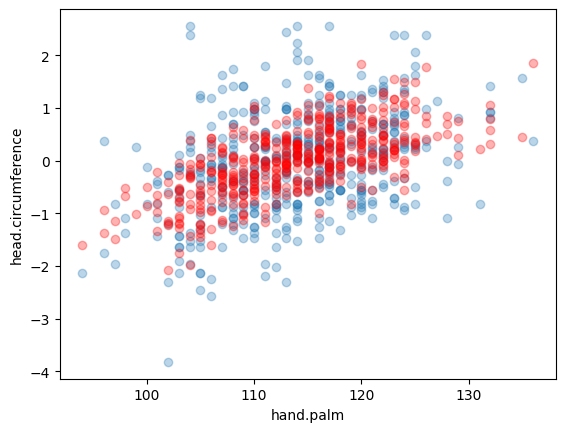

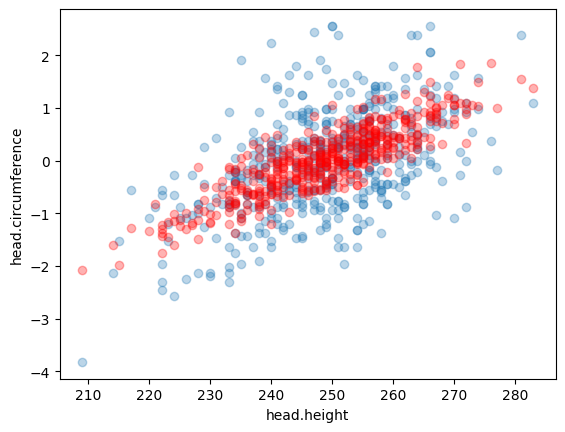

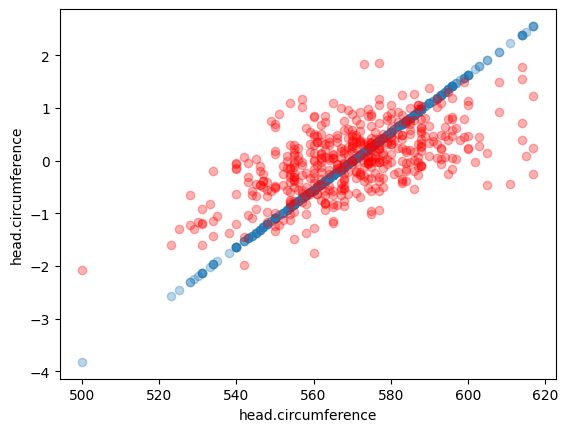

In [ ]:
## Run model on test data
## 4. Separate the independent variables

features_test = ansur_test_scaled_df.drop(columns=["head.circumference"])

## 6. Run the model on the test data
predicted_test = head_circ_model.predict(features_test)

##can create a non scaled version here using inverse transform

## 7. Measure error
regression_error(ansur_test_df["head.circumference"], predicted_test["head.circumference"])


ansur_test_df = pd.json_normalize(ansur_test_data)
##json normalize normalizes shape of data to make it rows and columns

## Plot predictions and interpret results
for fea in ansur_df:
    x = ansur_test_df[fea]
    ansur_orig = ansur_test_scaled_df["head.circumference"]
    ansur_pred = predicted_test["head.circumference"]
    plt.plot(x, ansur_orig , marker='o', linestyle='', alpha=0.3)
    plt.plot(x, ansur_pred , color='r', marker='o', linestyle='', alpha=0.3)
    plt.xlabel(fea)
    plt.ylabel("head.circumference")
    plt.show()





### Interpretation

<span style="color:hotpink;">
How well does your classifier perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:blue;">The classifier is good at predicting things that aren't outliers generally. The head circumferance probably does the poorest when predicting itself which is interesting. Overall its a pretty good classifer! Would probably be better if we were to add an interaction value.</span>

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [3]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg', '19-48.jpg']


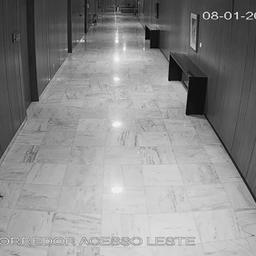

In [4]:
import random
from PIL import Image
from os.path import join
from image_utils import blur, edges, make_image, open_image
# TODO: check and see what is inside the list here

print(train_files[:5])

image_dir = "./data/images/0801-500/train/"
Image.open(join(image_dir, "19-48.jpg"))

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [6]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [7]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list


print(label_data [:5])
print(train_files[:5])


[23, 24, 6, 0, 15]
['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg', '19-48.jpg']


The labels and the filenames won't match exactly since labels start at $0$ and the filenames skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

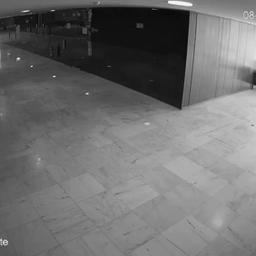

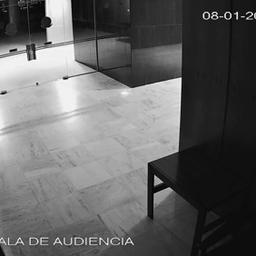

In [8]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

And now might not be a bad time to peek into the `data/images/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [9]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,99,99,99,99,99,99,99,99,99,99,...,113,115,111,106,105,106,108,107,106,23
1,89,89,89,91,95,98,100,100,101,101,...,50,60,50,49,58,61,55,54,60,24
2,138,129,66,121,134,55,58,47,67,72,...,180,179,179,179,179,179,179,179,179,6
3,17,17,17,17,17,17,17,17,22,22,...,66,64,65,67,68,69,69,68,67,0
4,49,53,43,50,53,49,59,53,47,50,...,182,176,181,187,188,185,181,179,179,15


### Test Files

If that worked, repeat the process for the test files inside the `./data/images/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

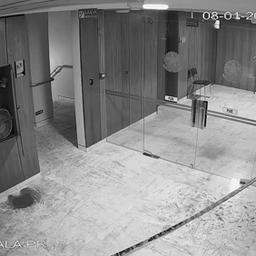

1573
['15709132.jpg', '12405239.jpg', '10894318.jpg', '15584424.jpg', '10656623.jpg']


In [11]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test") if f.endswith(".jpg")]
image_dir = "./data/images/0801-500/test/"
display(Image.open(join(image_dir, "15709132.jpg")))
# TODO: check its length and content
print(len(test_files))
print(test_files[:5])

test_pixel_data = []

# TODO: loop over files and load their pixels into a list
for fname2 in test_files:
  #print(fname2)
  #print(test_files[0])
  img = open_image(path.join("./data/images/0801-500/test/", fname2))
  test_pixel_data.append(img.pixels)


# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)


Check the `DataFrame`

In [12]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,101,101,100,100,100,99,98,98,105,104,...,172,185,180,180,182,185,189,189,185,180
1,131,131,131,132,133,134,135,136,135,135,...,149,149,149,147,145,145,145,145,143,141
2,54,54,54,53,54,57,62,66,61,59,...,168,160,156,159,162,162,161,162,165,168
3,141,172,202,198,221,231,232,219,187,148,...,33,34,24,25,25,25,25,25,26,26
4,9,14,14,20,29,22,13,16,11,14,...,3,3,1,1,1,1,1,1,1,1


Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [13]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error
7. Run model on test data, measure error, plot predictions, interpret results

In [14]:
# TODO: create a brand new classifier
classifier = RandomForestClassifier()
# TODO: fit the model -- this is just for preparation step with training data
classifier.fit(train_features,train_df["label"])
# TODO: run predictions
train_predictions = classifier.predict(train_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)



1.0

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [15]:

# TODO: run predictions
test_predictions = classifier.predict(test_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions)



0.6560712015257469

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:blue;">The classifier does surprisngly well for just using the first 10 pixels in every image. It would probably do better if we were to spread out the pixels chosen rather than just the first 10. The more pixels we choose would also probably improve the accuracy as well. Below I chose the same number of columsns but instead chose last and first 5</span>

In [17]:
first_5_columns = train_df.columns[:5]
last_5_columns = train_df.columns[-6:-1]


chosen_columns = list(first_5_columns) + list(last_5_columns)

train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

# TODO: create a brand new classifier
classifier = RandomForestClassifier()
# TODO: fit the model -- this is just for preparation step with training data
classifier.fit(train_features,train_df["label"])
# TODO: run predictions
train_predictions = classifier.predict(train_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)


# TODO: run predictions
test_predictions = classifier.predict(test_features)
# TODO: measure classification accuracy
CamUtils.classification_accuracy(test_files, test_predictions)





0.817546090273363